<a href="https://colab.research.google.com/github/bhashitha99/Graph_neural_network/blob/main/GNN_Experiment_KarateClub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GNN Explaination:**
The explaination in this notebook is based on the GNNN example from the PyG documentation
https://pytorch-geometric.readthedocs.io/en/latest/notes/colabs.html
- Introduction: Hands-on Graph Neural Networks

In [1]:
!python --version

Python 3.10.12


In [2]:
!python -c "import torch; print(torch.version.cuda)"

12.1


In [3]:
# PyTorch version
!python -c "import torch; print(torch.__version__)"

2.3.0+cu121


In [4]:
# Install required packages.
#!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
#!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
#!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.11.0+cu113.html
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.11.0+cu113.html
!pip install torch-geometric


Looking in links: https://data.pyg.org/whl/torch-1.11.0+cu113.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: Operation cancelled by user
Looking in links: https://data.pyg.org/whl/torch-1.11.0+cu113.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... canceled
ERROR: Operation cancelled by user
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.5 MB/s eta 0:00:00


In [5]:
# Helper function for visualization.
%matplotlib inline
import torch
import networkx as nx
import matplotlib.pyplot as plt

In [6]:
from torch_geometric.datasets import KarateClub

In [7]:
dataset = KarateClub()

In [8]:
data = dataset[0]  # Get the first graph object.
print(data)

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


# **Train Mask**
- (4) There also exists an additional attribute called train_mask, which describes for which nodes we already know their community assigments.

In [9]:
data.stores

[{'x': tensor([[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.]]), 'edge_index': tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
           1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
           3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
           7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
          13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
          21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
          27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
          31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
          33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33],
    

In [10]:
data.y

tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])

In [11]:
data.train_mask

tensor([ True, False, False, False,  True, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False])

Above only 4 nodes have mask value set as True, it means only 4 out of 34 nodes have community or class assignment, rest of the 30 nodes needs community assignment.

Train Mask -> In total, we are only aware of the ground-truth labels of 4 nodes (one for each community), and the task is to infer the community assignment for the remaining nodes.

# **Validation and Test Mask:**

If the graph holds the additional attributes i.e. val_mask and test_mask, which denotes which nodes should be used for validation and testing.

# **GNN Objective:**
- We have 4 nodes only with the community assigned so we need to assign remaining 30 nodes

In [12]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.

        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


In [13]:
model = GCN()

_, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

Embedding shape: [34, 2]


In [14]:
h

tensor([[ 0.0962,  0.0115],
        [ 0.0235,  0.0129],
        [ 0.0432,  0.0201],
        [ 0.0401,  0.0162],
        [ 0.0522, -0.0054],
        [ 0.0775,  0.0011],
        [ 0.0763,  0.0031],
        [ 0.0300,  0.0131],
        [ 0.0107,  0.0181],
        [ 0.0014,  0.0195],
        [ 0.0575, -0.0035],
        [ 0.0867,  0.0090],
        [ 0.0353,  0.0106],
        [ 0.0242,  0.0179],
        [-0.0114,  0.0138],
        [-0.0109,  0.0173],
        [ 0.0740,  0.0046],
        [ 0.0188,  0.0012],
        [-0.0139,  0.0210],
        [ 0.0068,  0.0108],
        [ 0.0077,  0.0168],
        [ 0.0014,  0.0033],
        [-0.0065,  0.0175],
        [ 0.0657,  0.0242],
        [ 0.1390,  0.0069],
        [ 0.1296,  0.0110],
        [-0.0140,  0.0309],
        [ 0.0852,  0.0189],
        [ 0.0415,  0.0141],
        [ 0.0032,  0.0333],
        [-0.0036,  0.0152],
        [ 0.0995,  0.0135],
        [ 0.0102,  0.0337],
        [ 0.0181,  0.0381]], grad_fn=<TanhBackward0>)

In [15]:
def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(12,8))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

In [16]:
from sklearn.manifold import TSNE

def visualize_tsne(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [17]:
data.y

tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])

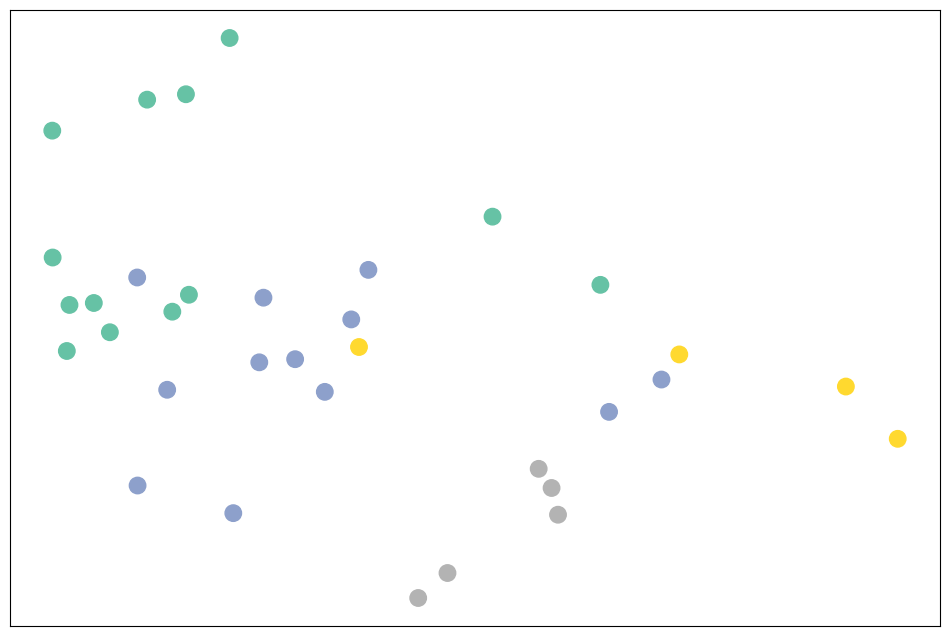

In [18]:
visualize_embedding(h, color=data.y)
# Note : 4 classes are visible
# Nodes of the same color (community) are already closely clustered together in the embedding space, although the weights of our model are initialized completely at random

In [19]:
import time
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))


<IPython.core.display.Javascript object>

In [20]:
model = GCN()

In [21]:
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.


In [23]:
# added by me
final_h = h

In [24]:
def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h

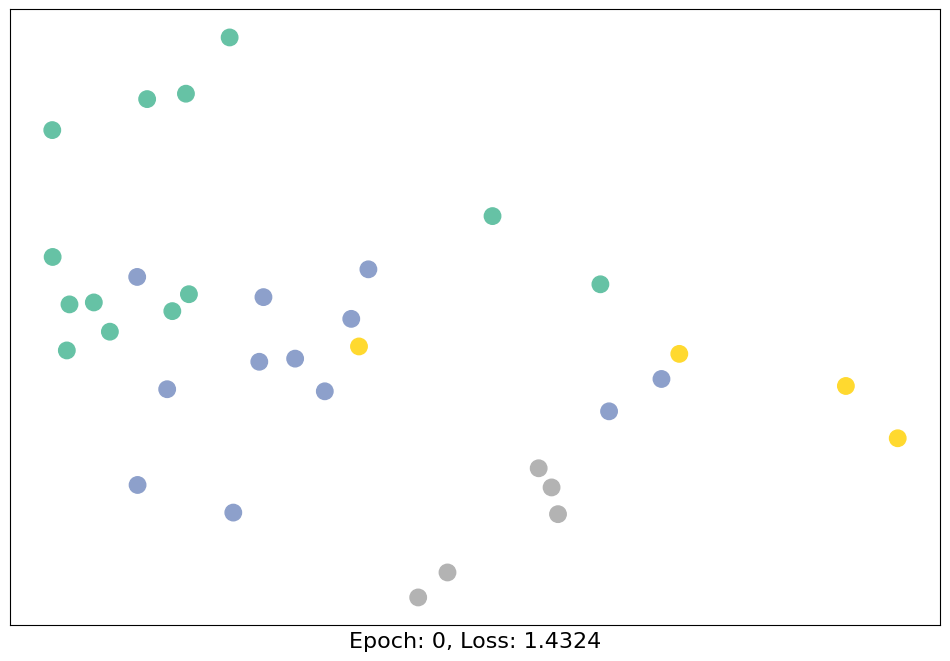

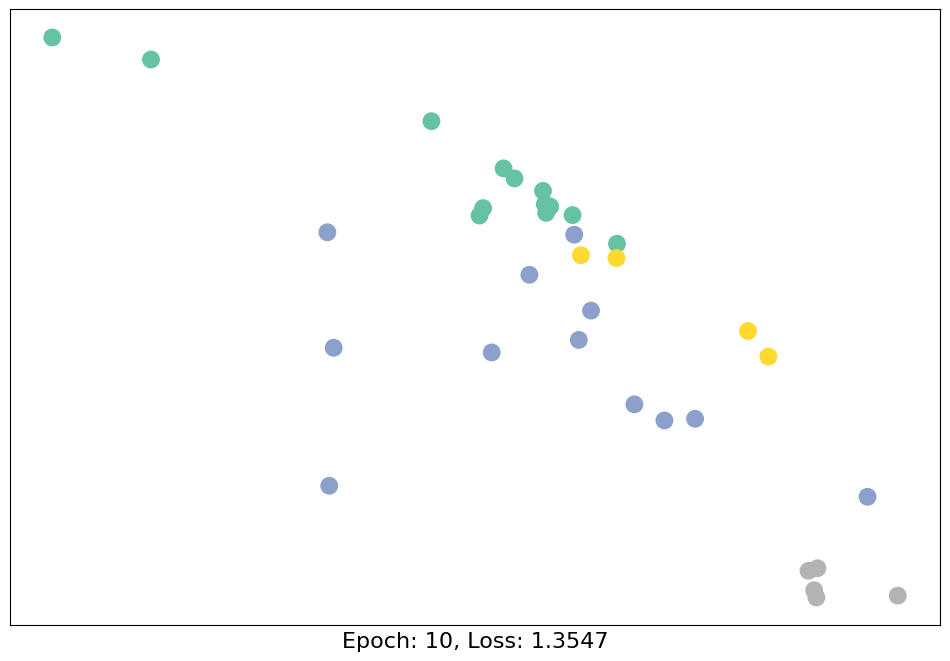

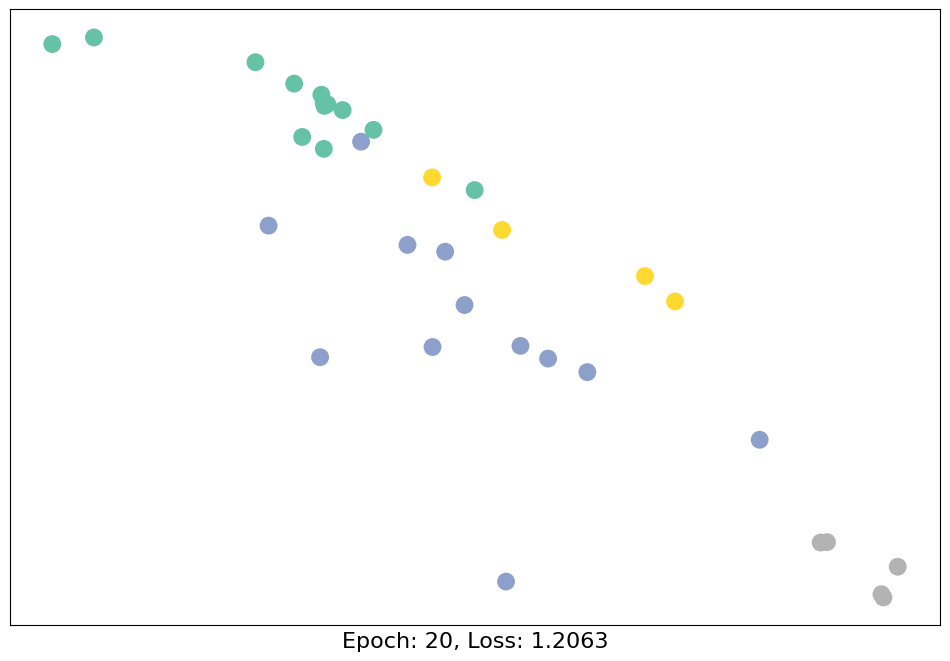

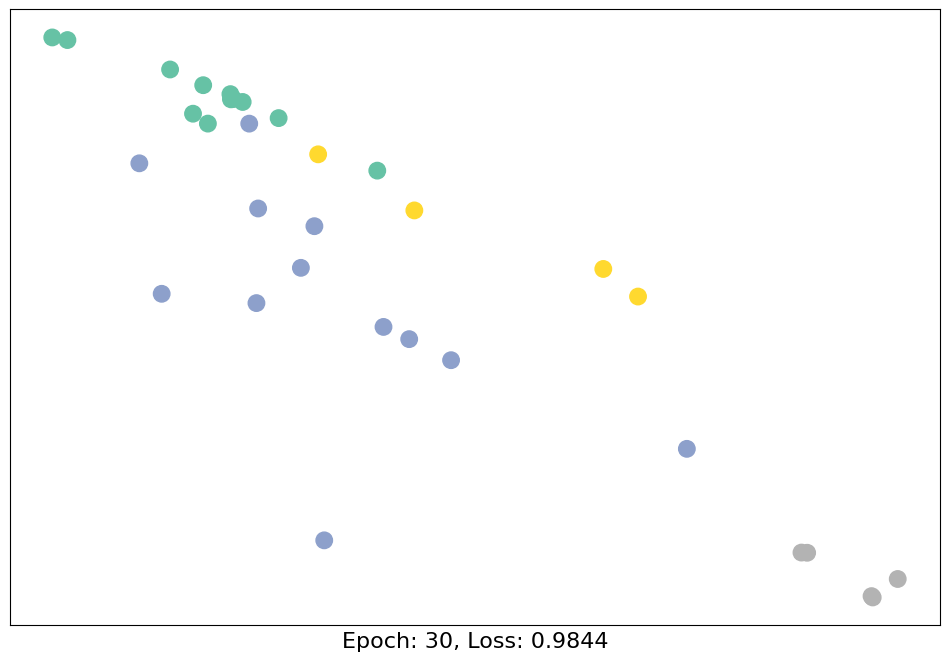

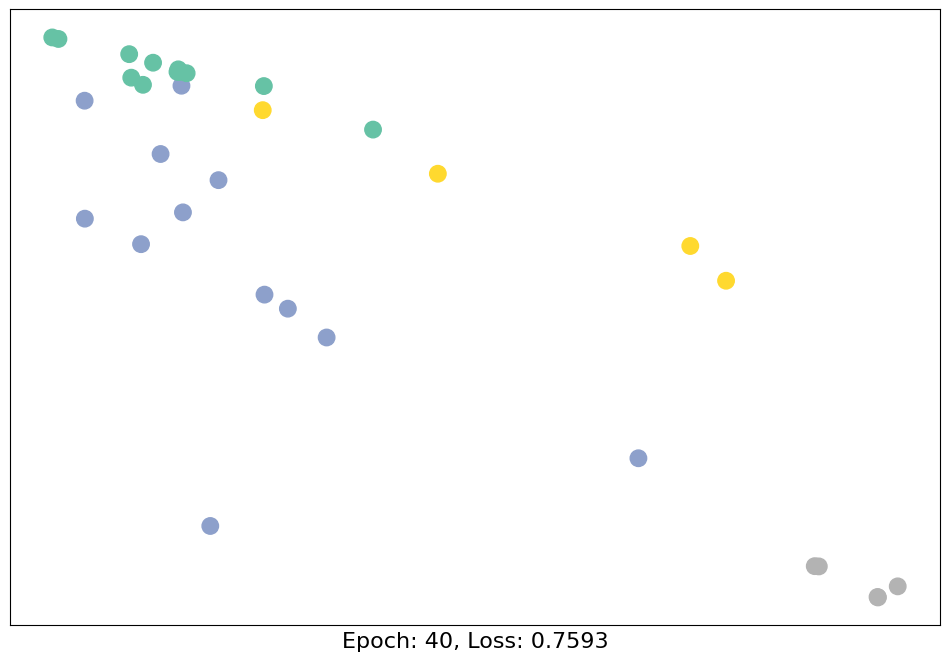

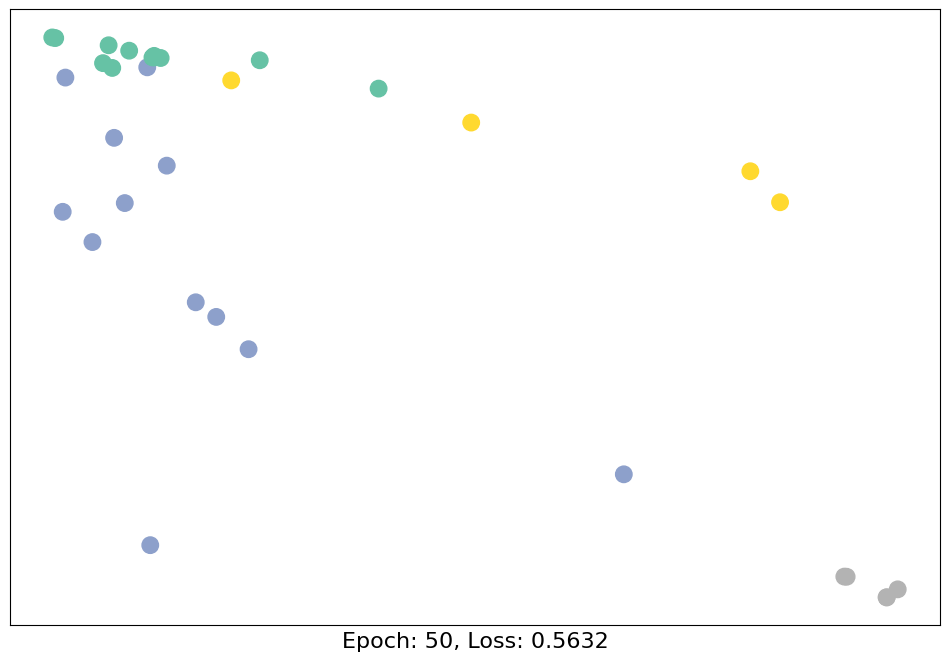

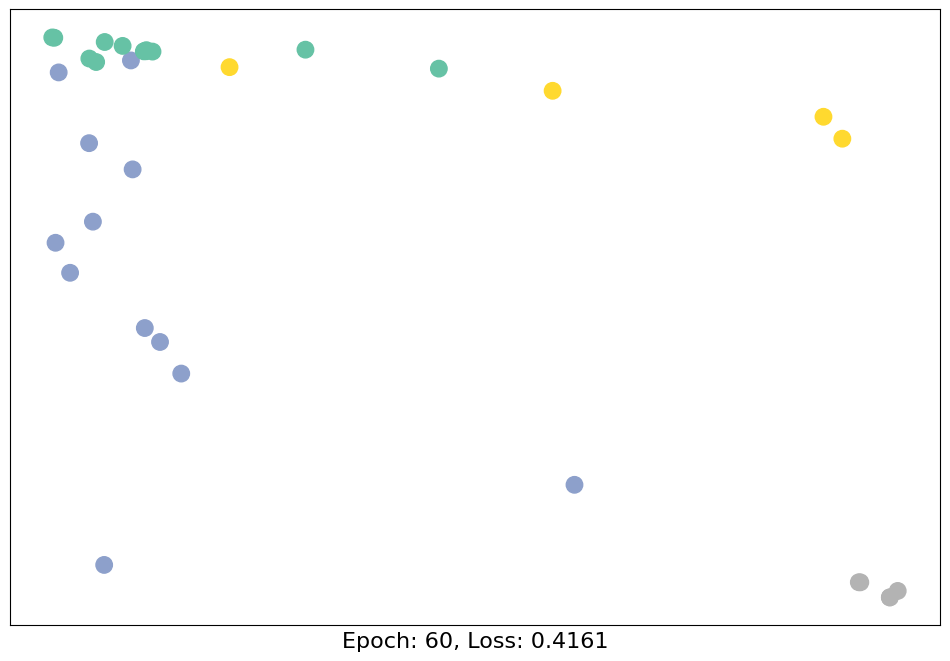

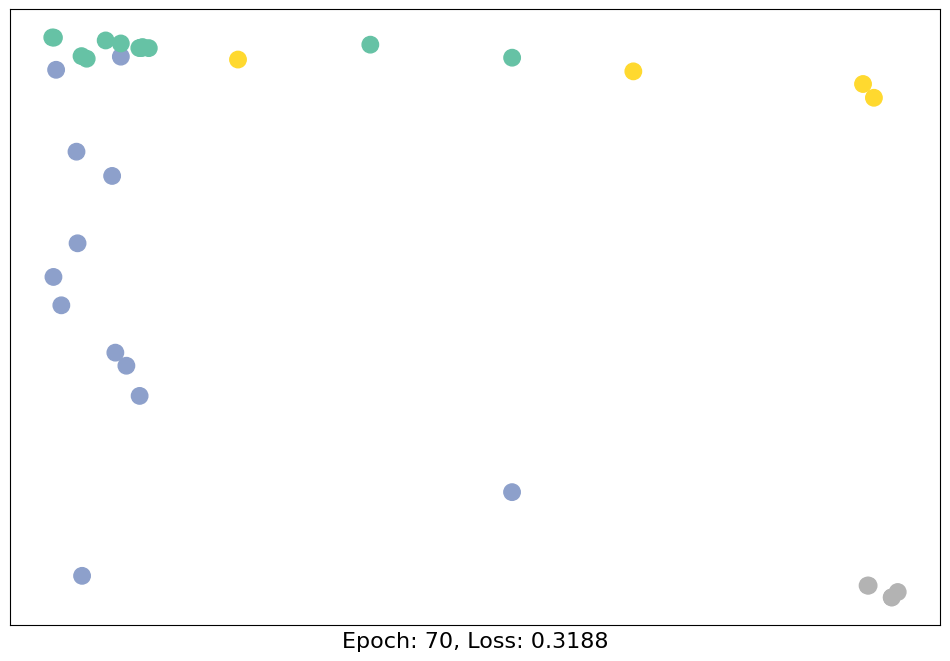

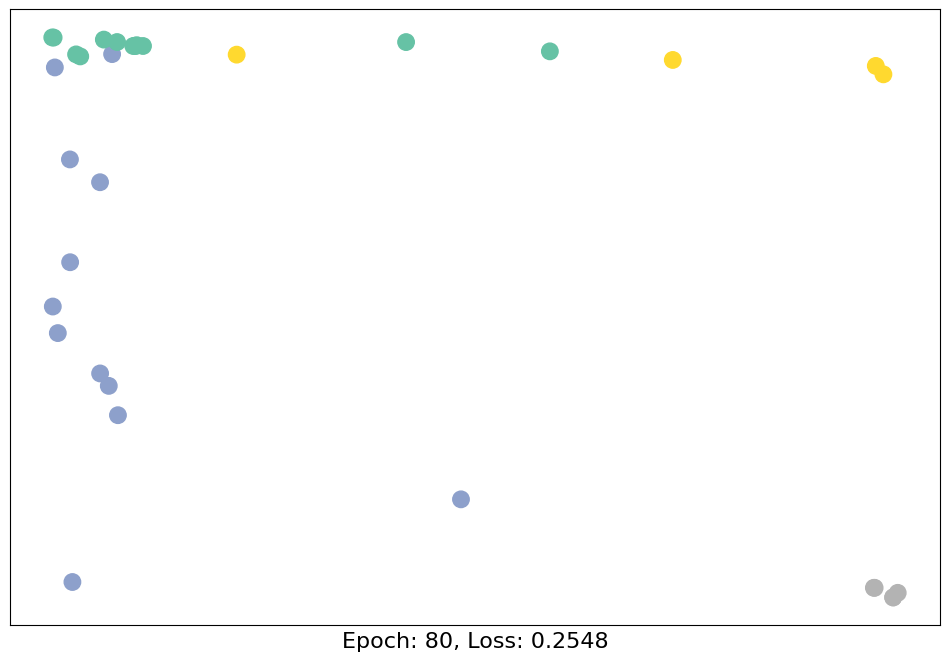

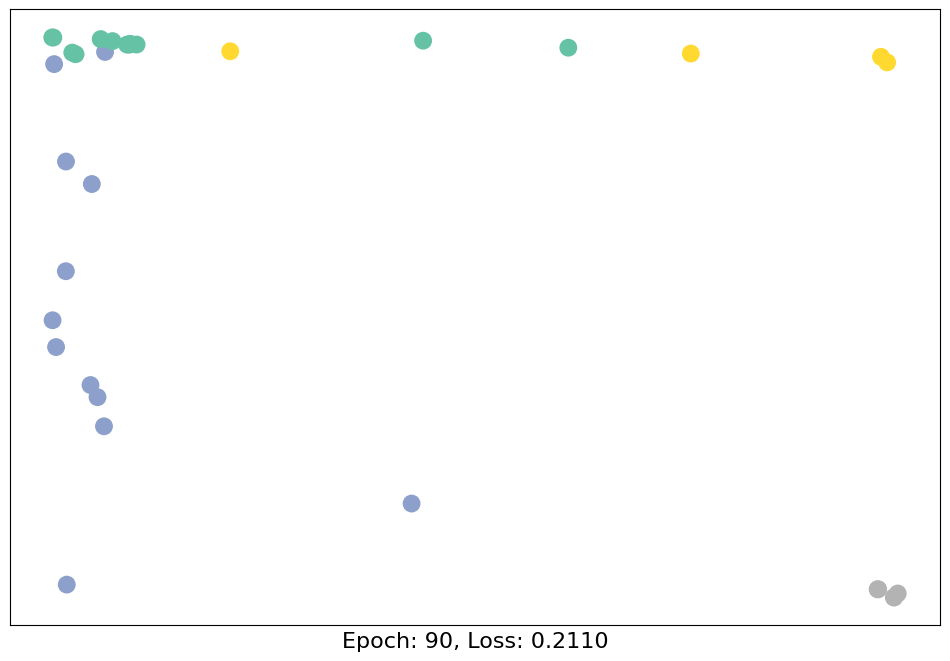

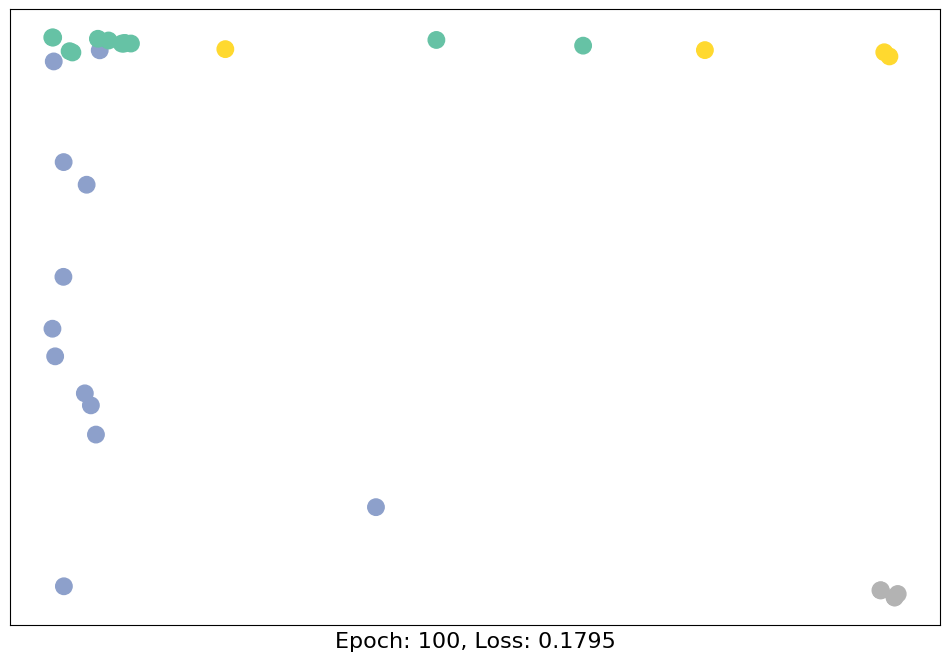

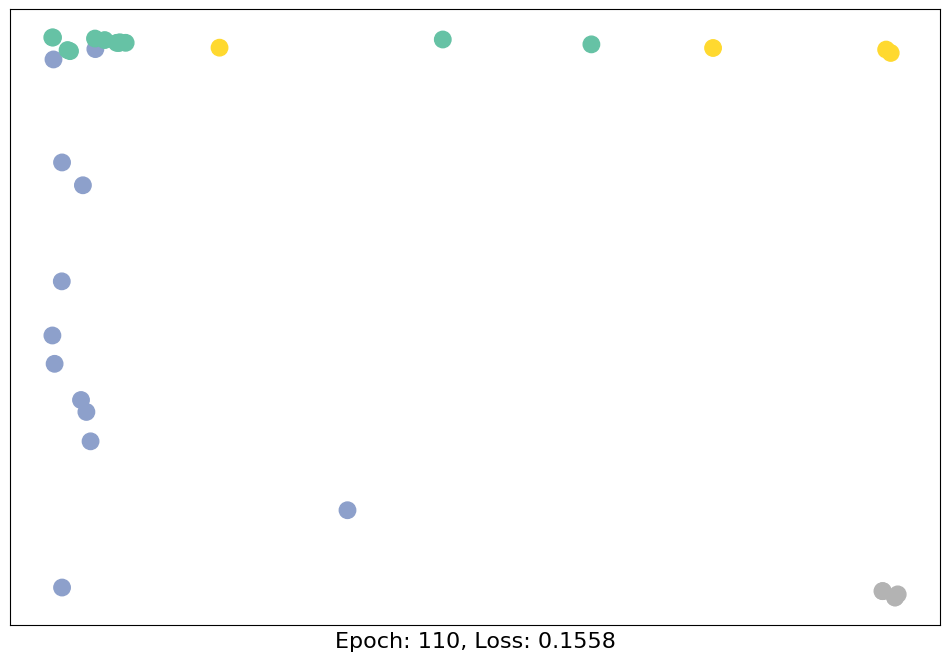

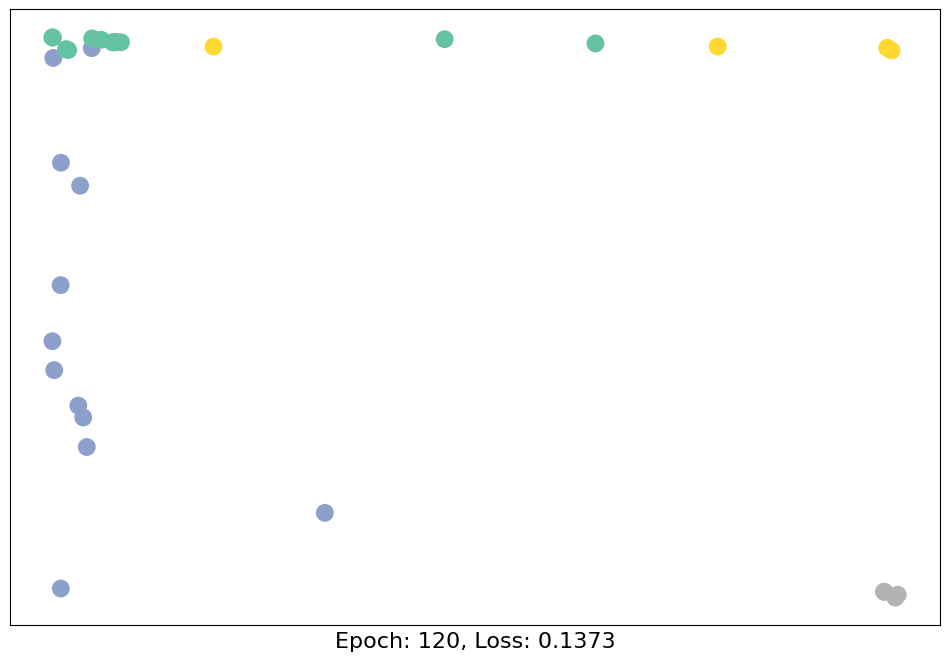

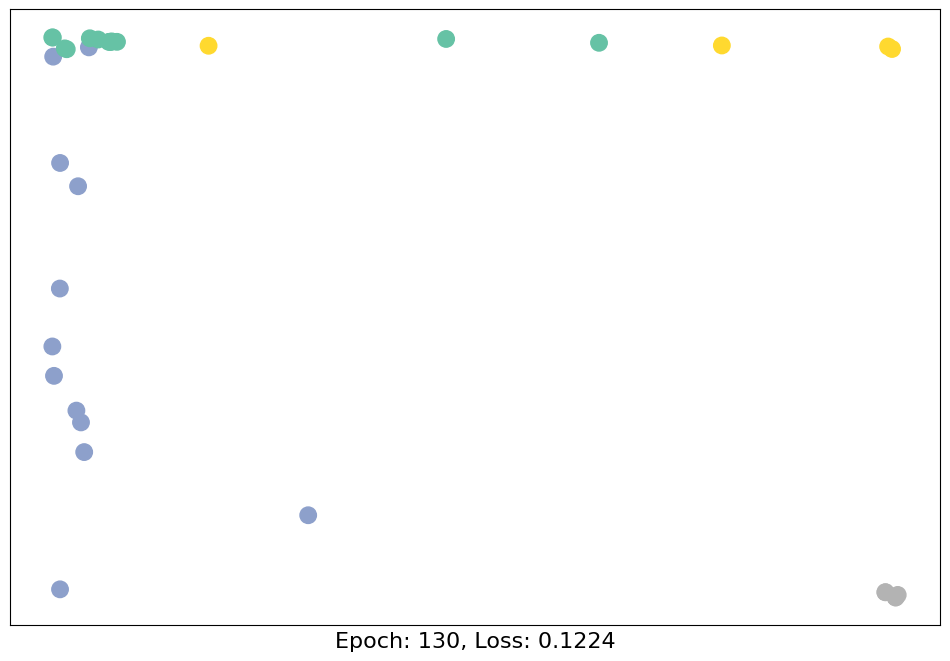

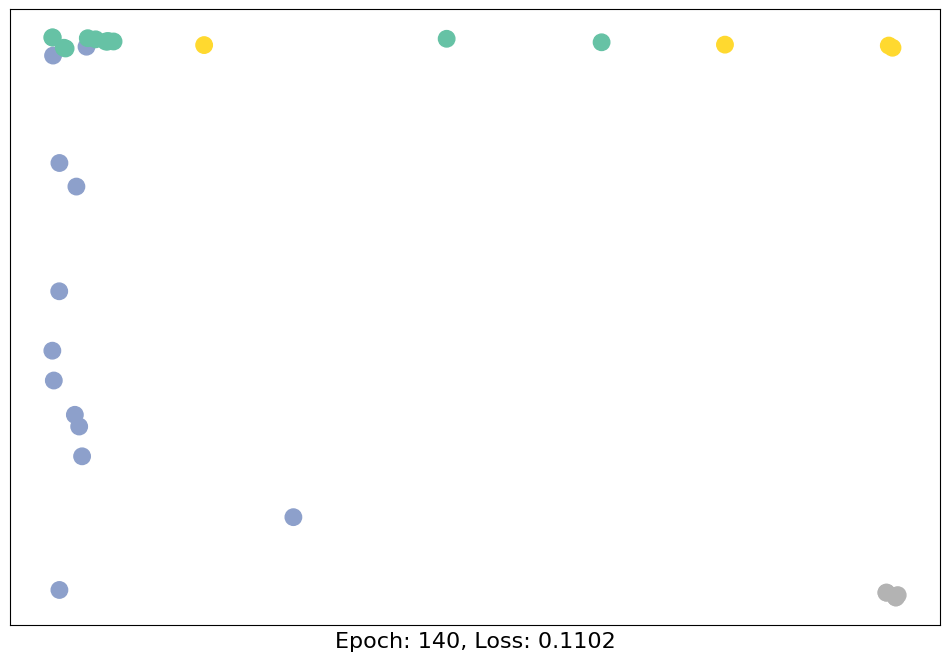

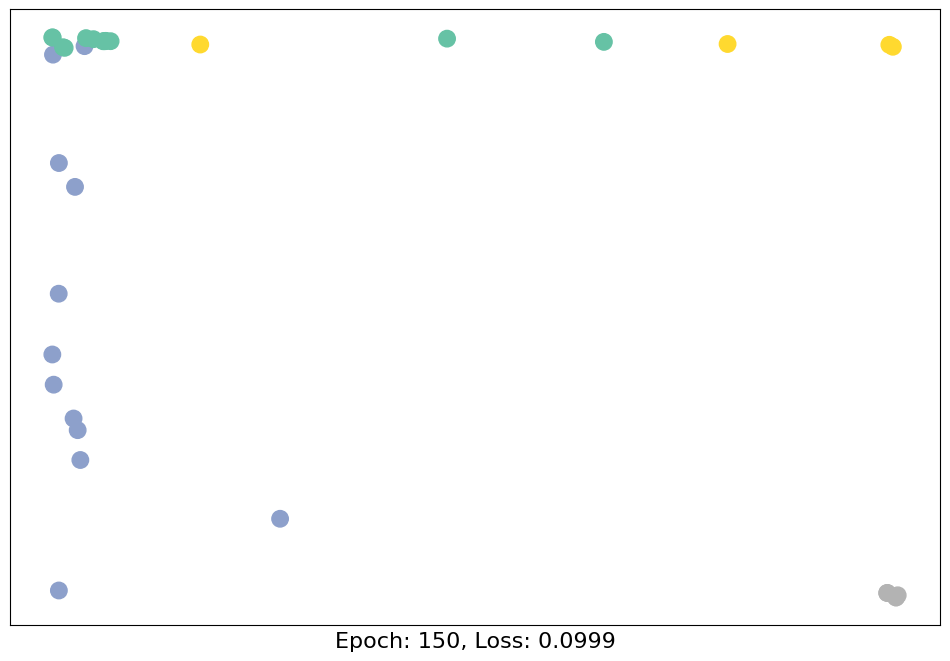

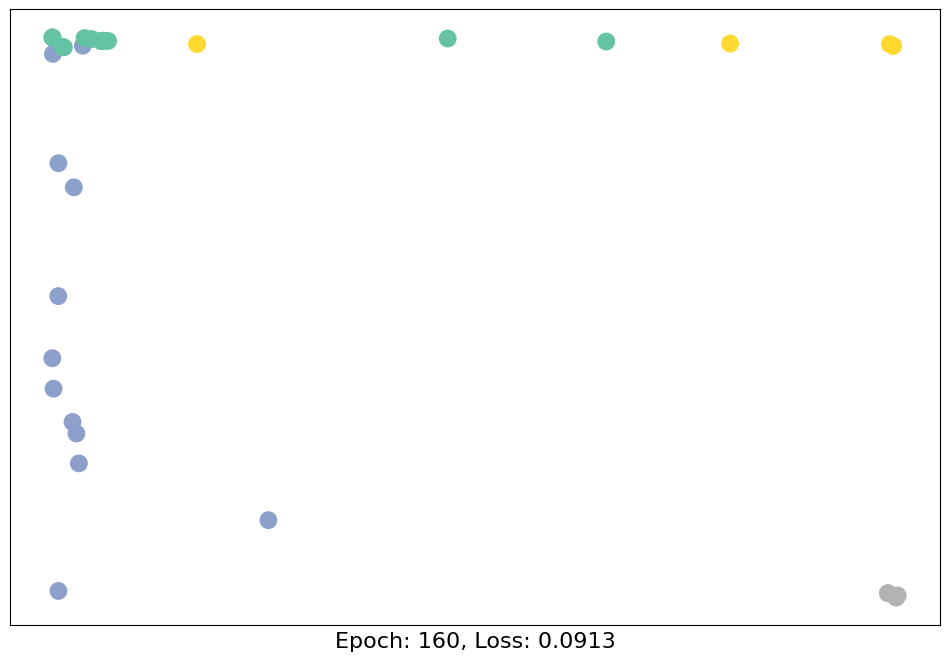

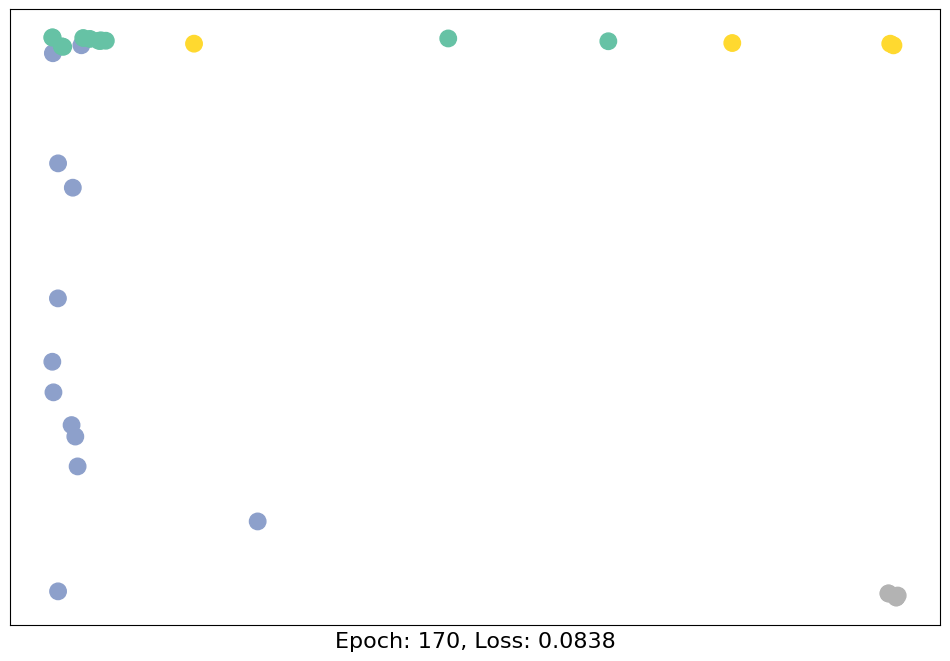

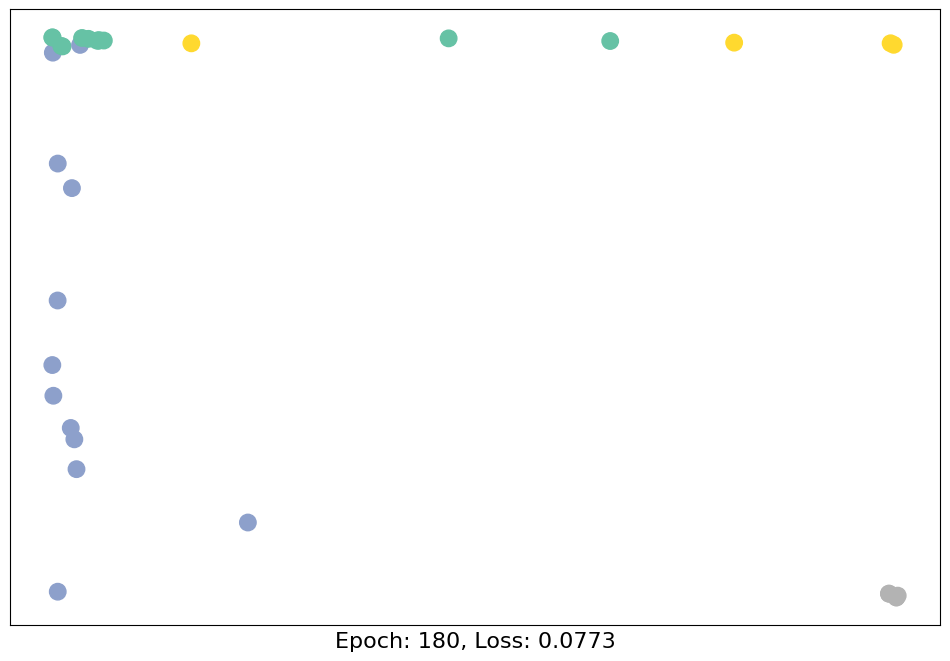

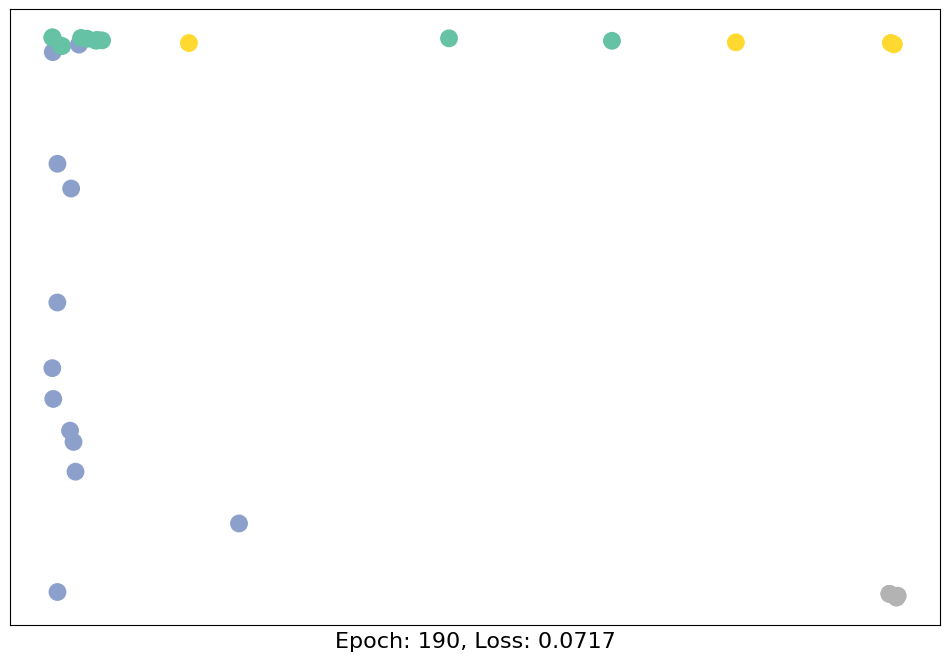

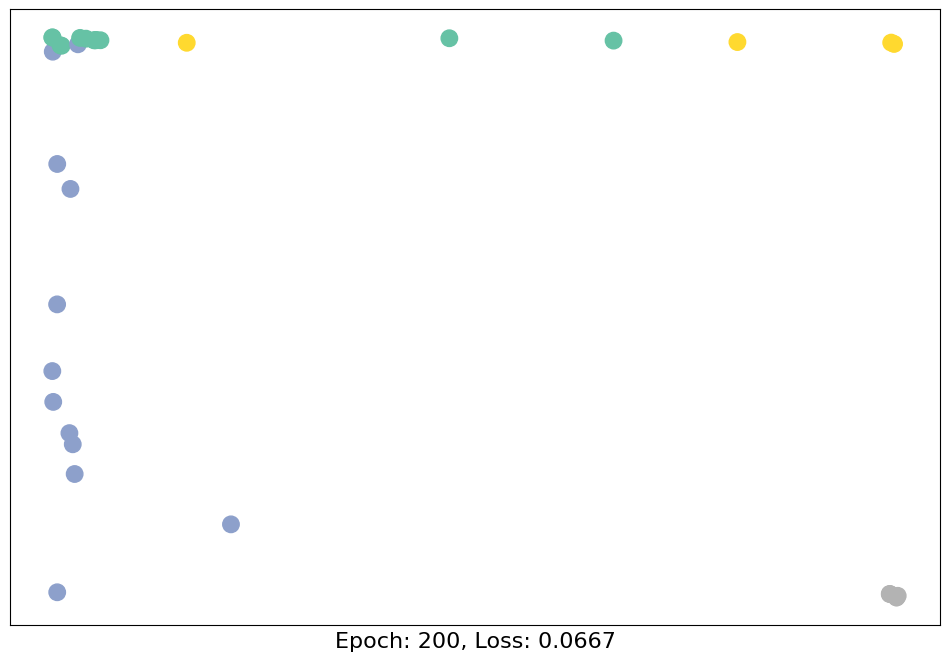

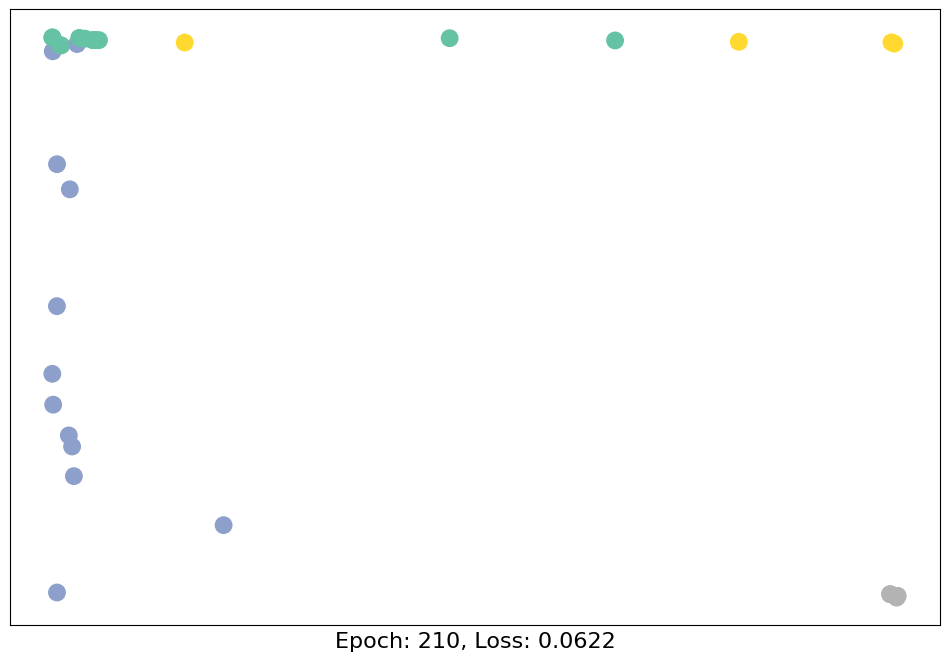

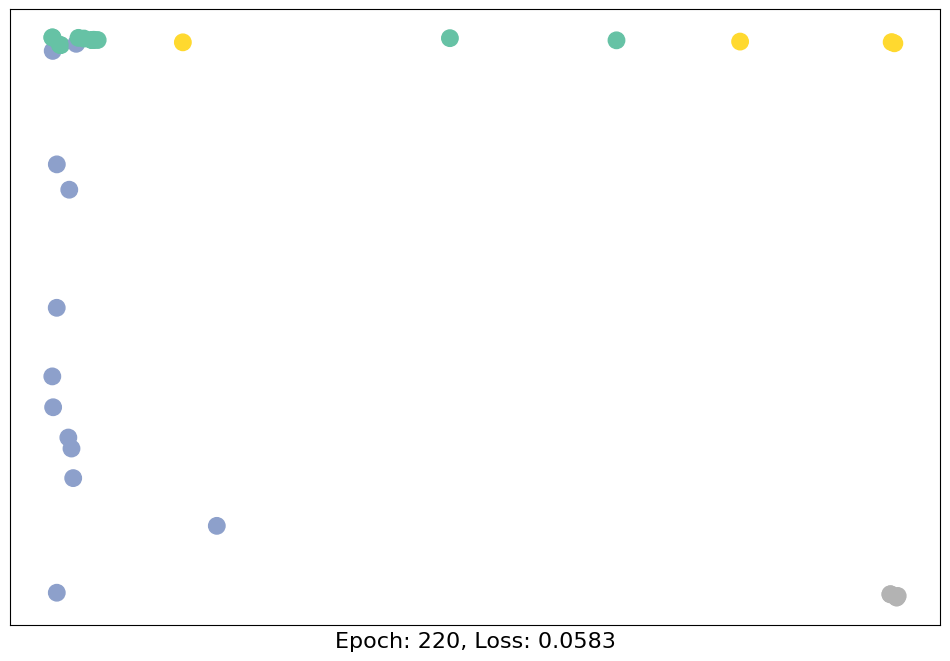

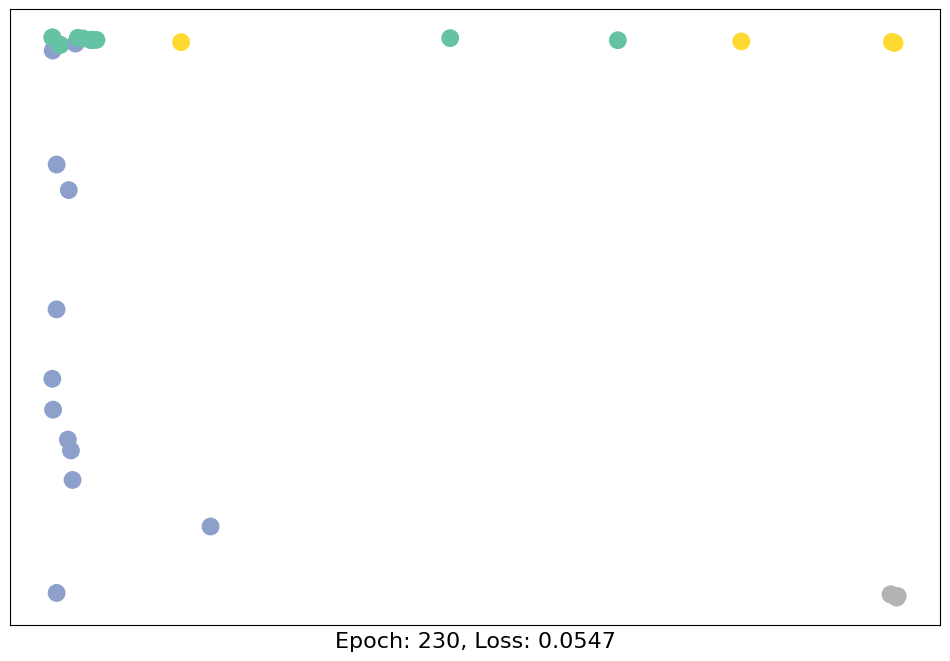

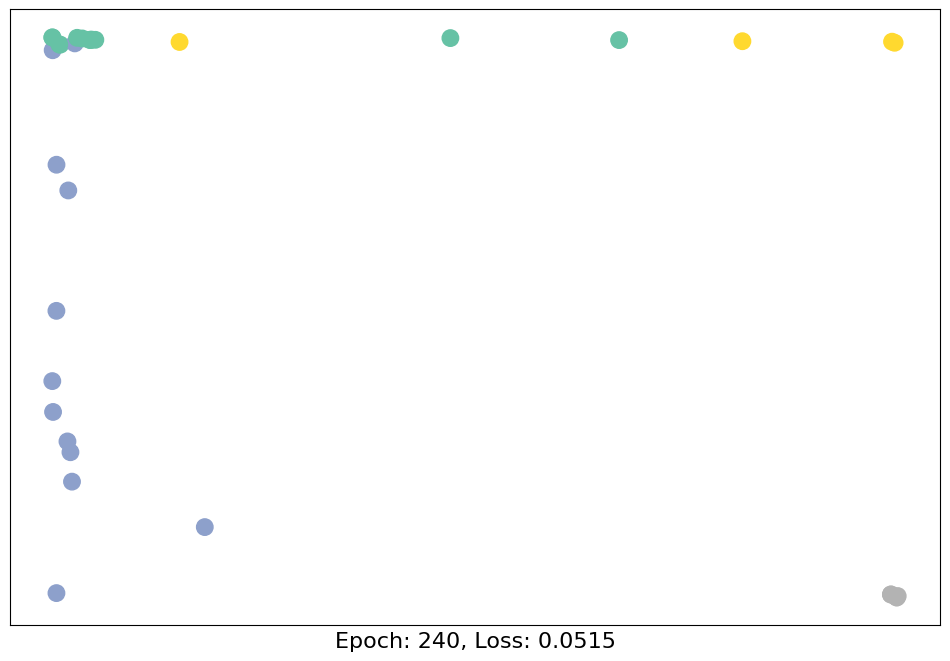

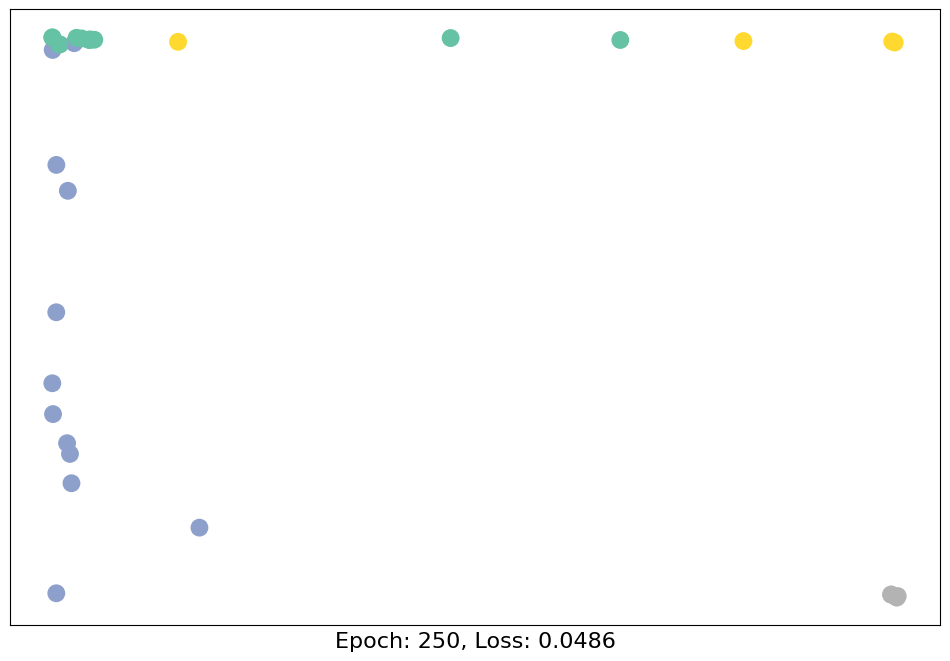

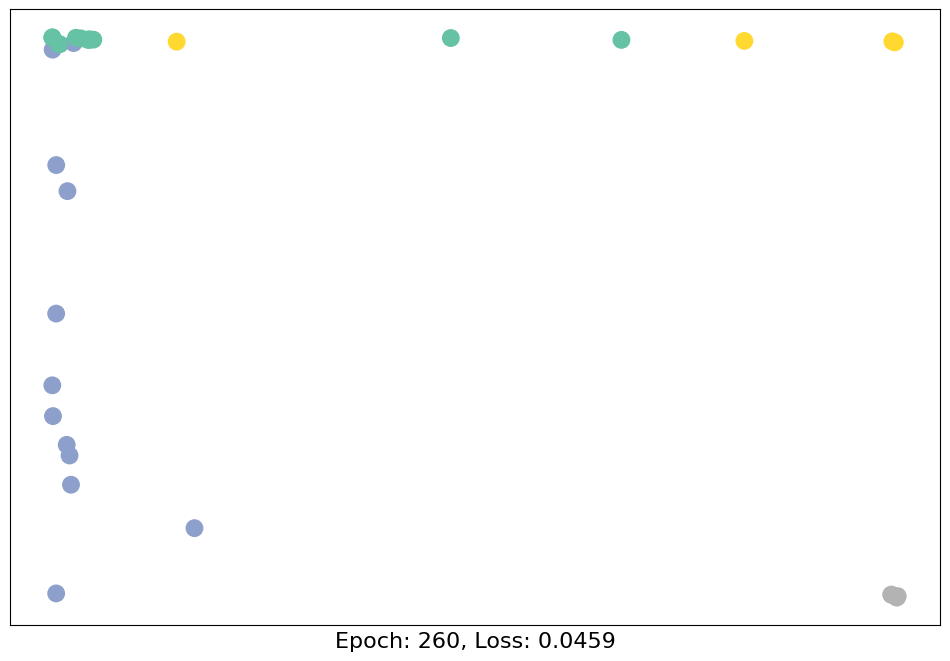

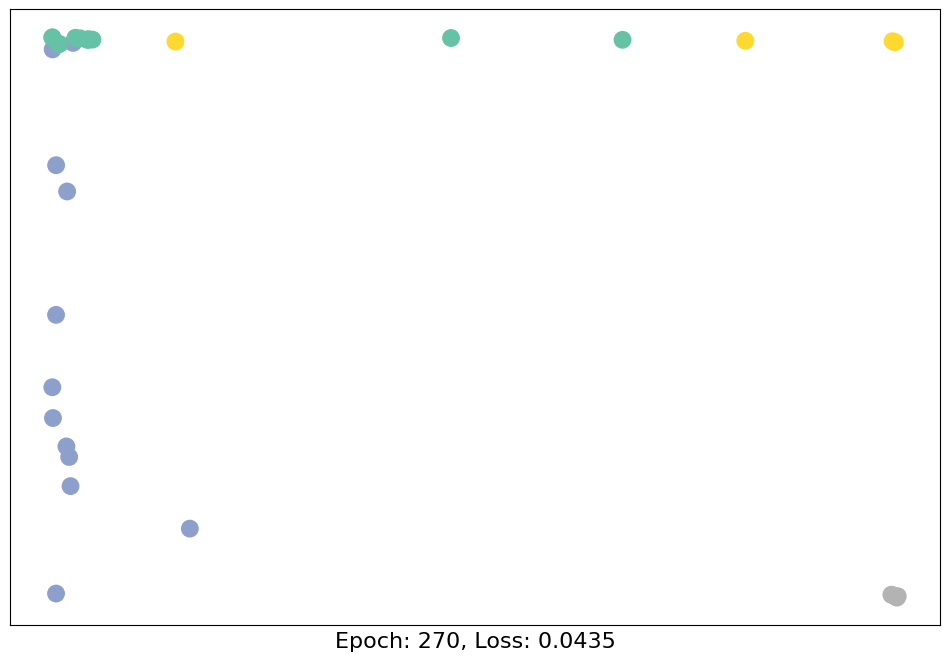

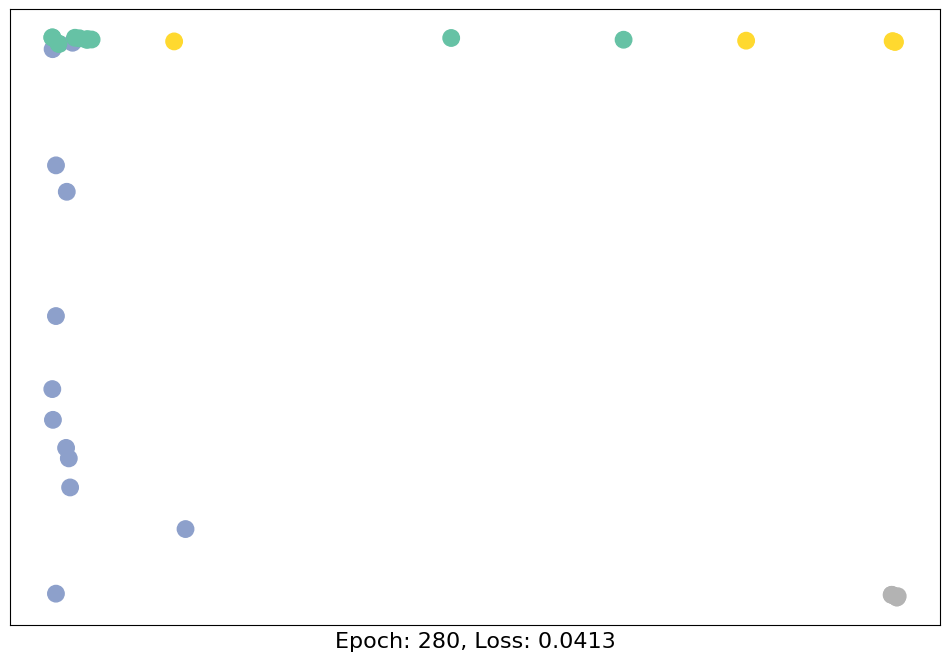

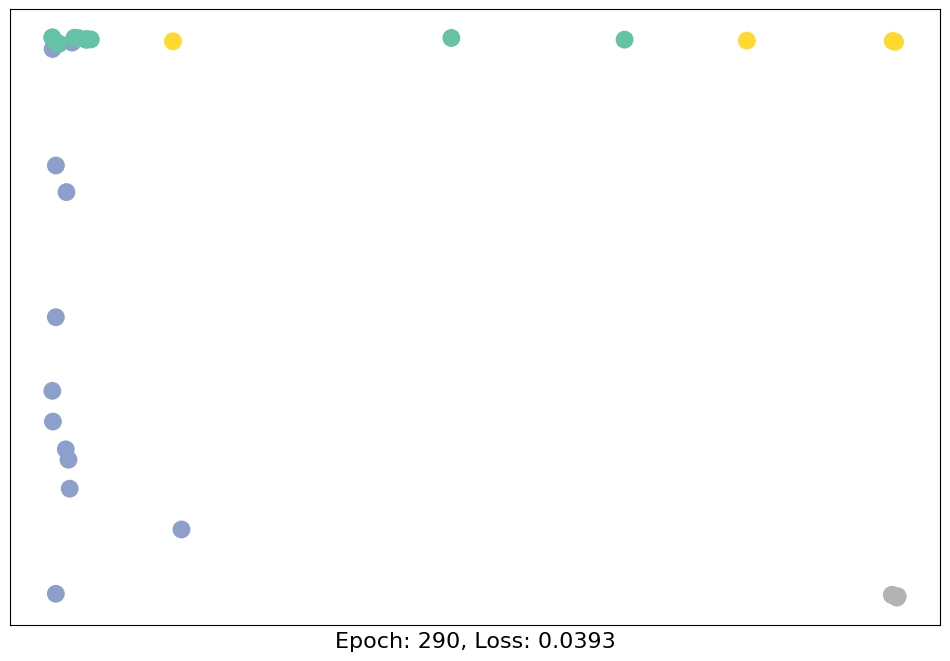

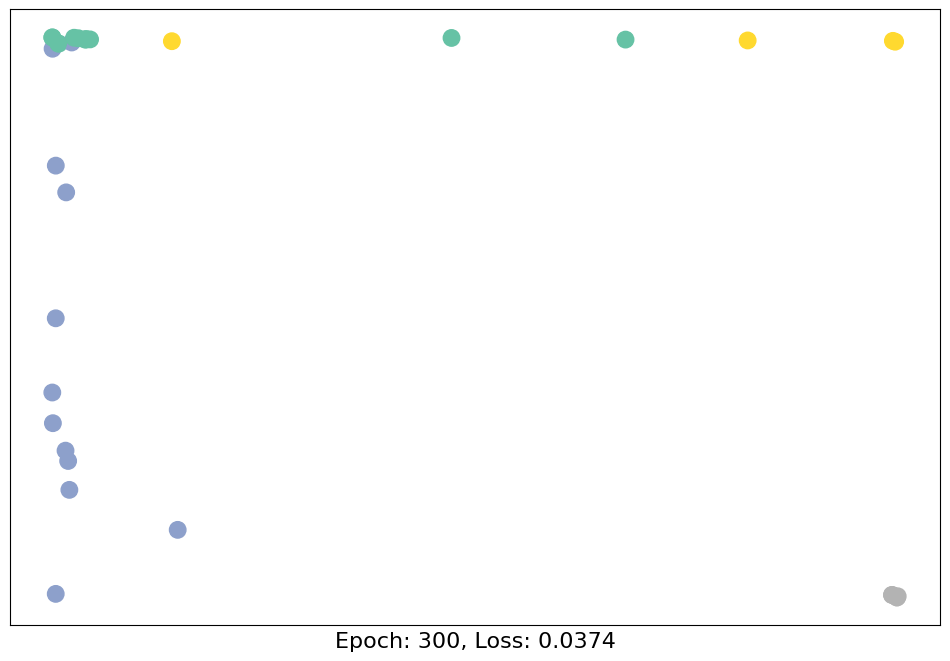

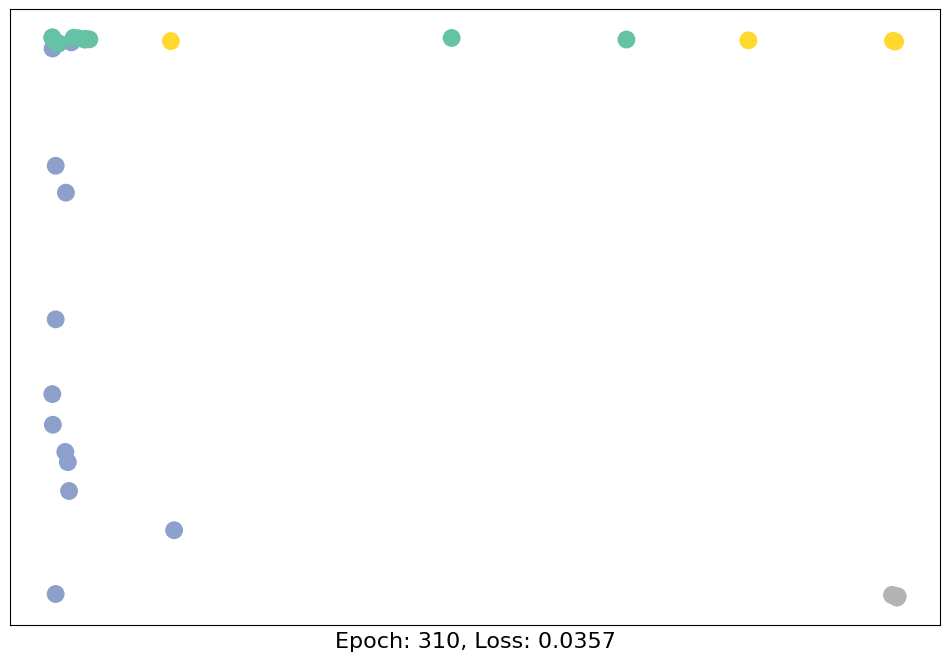

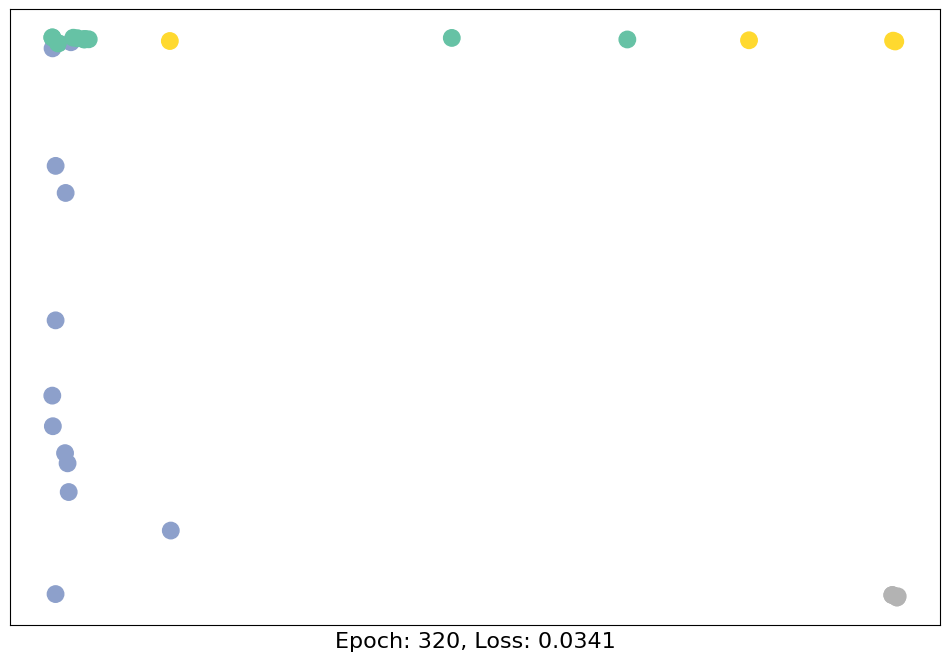

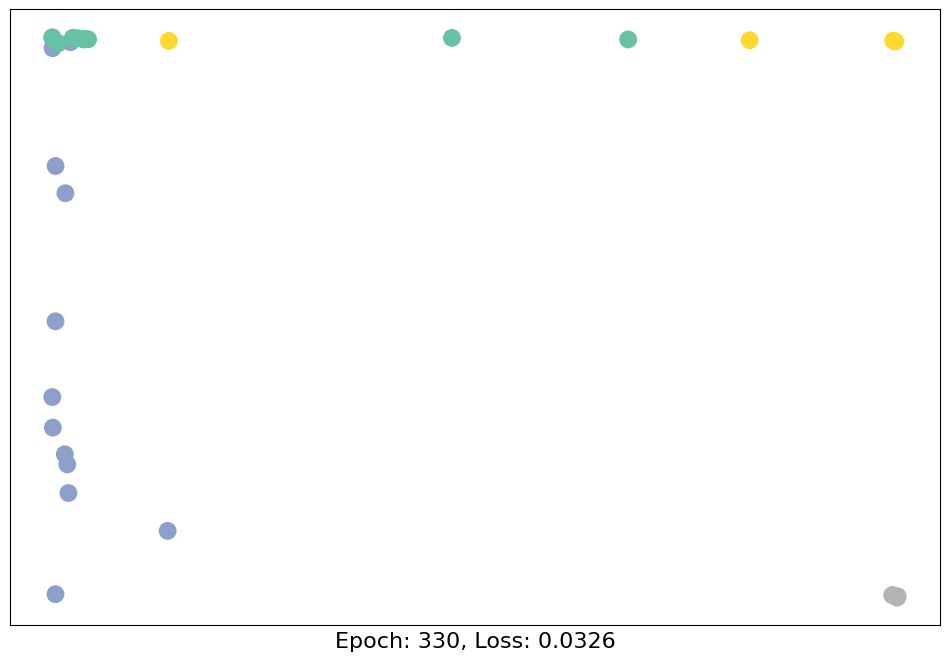

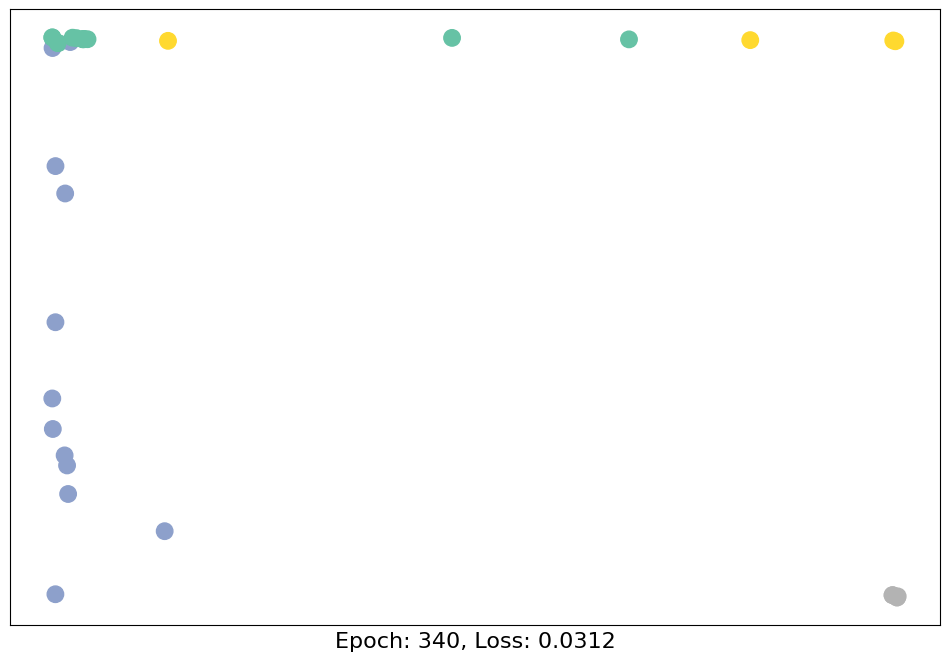

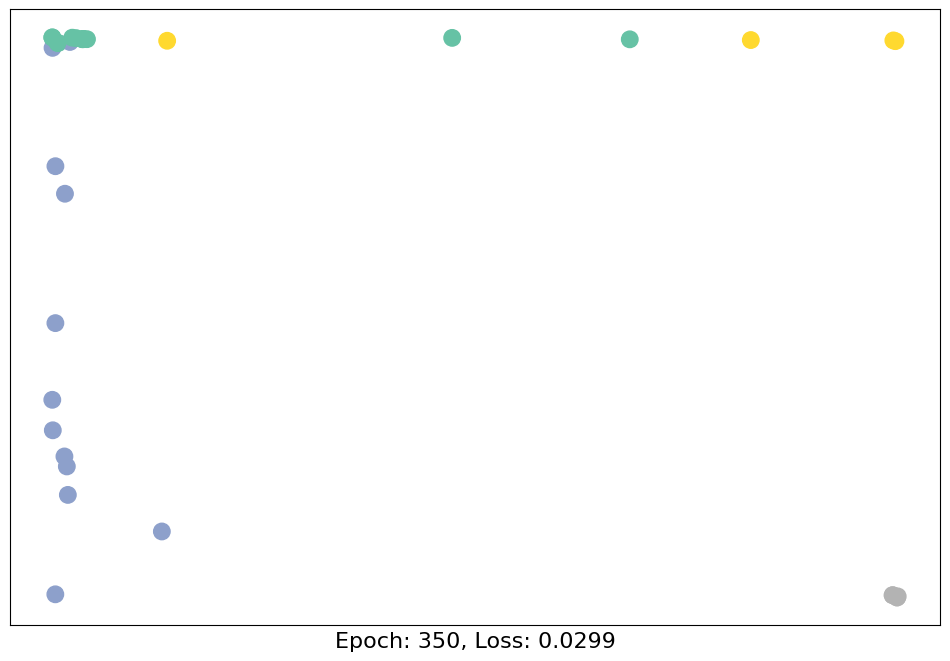

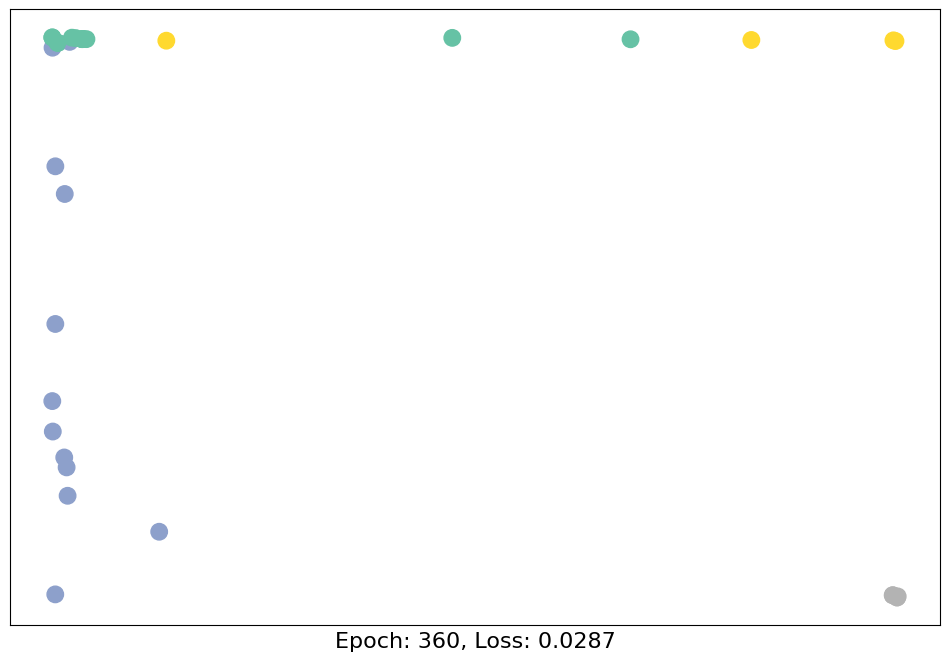

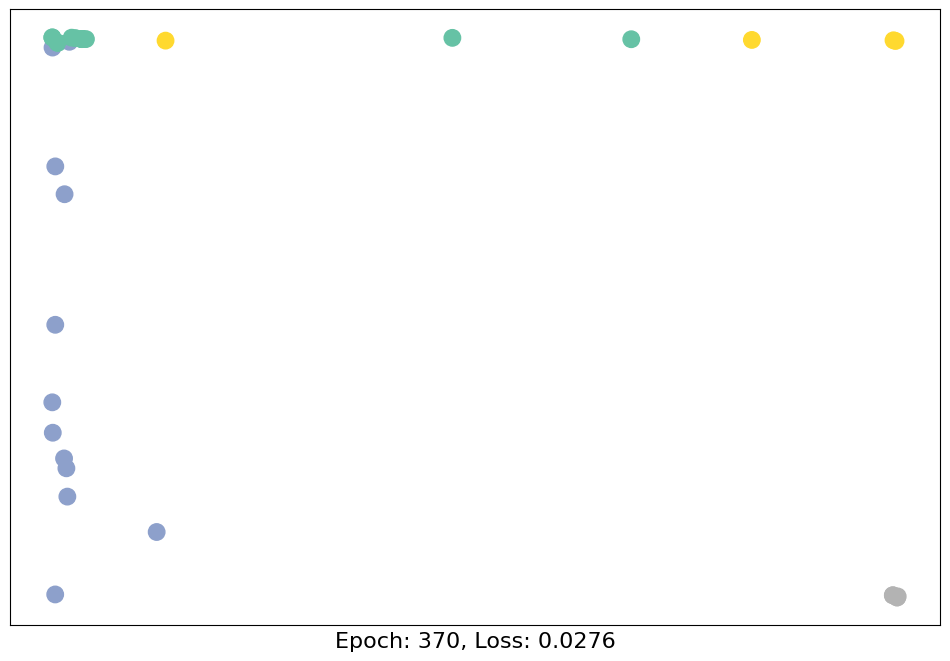

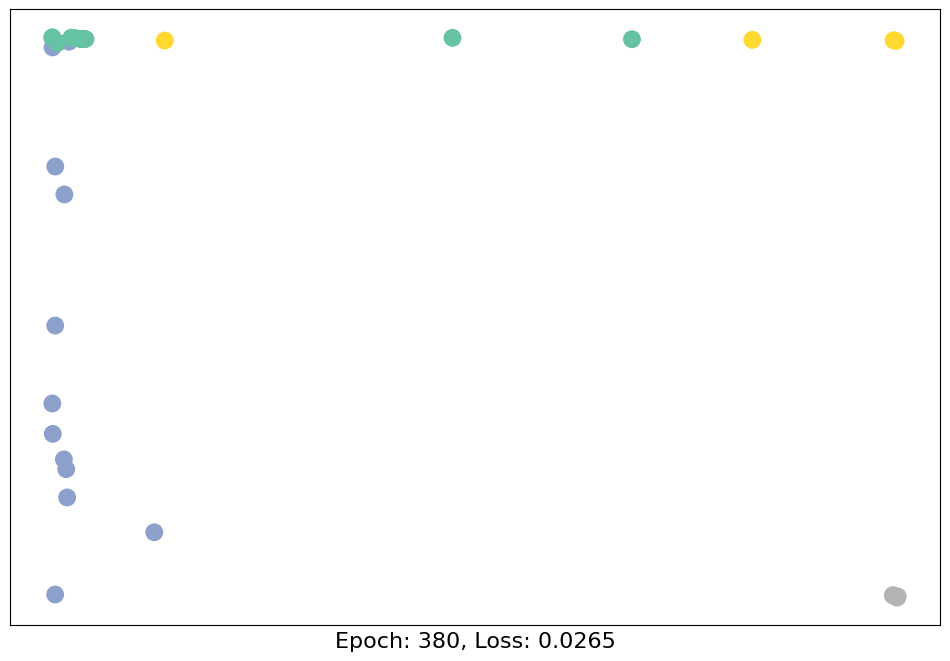

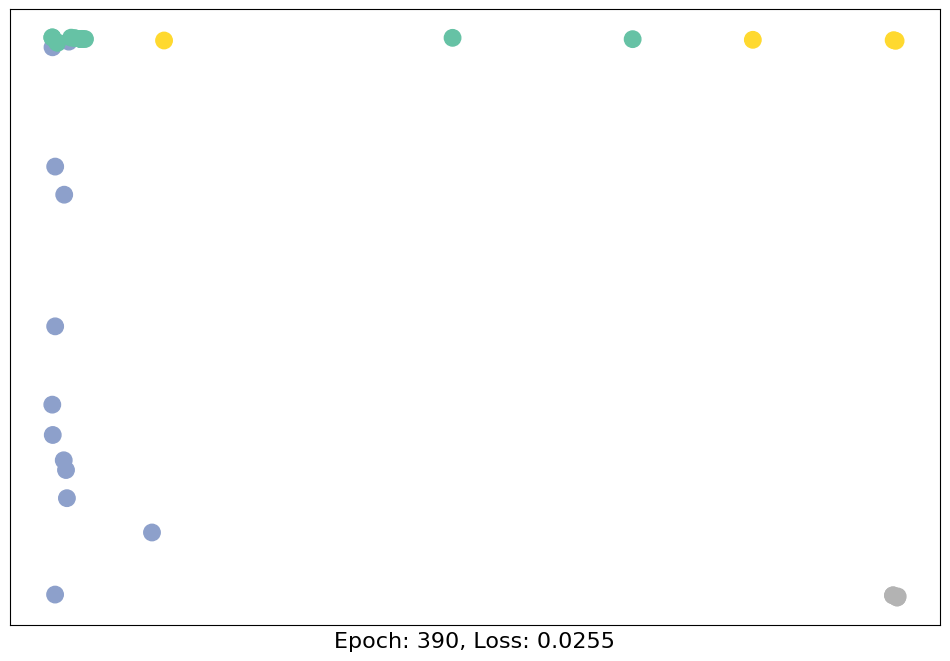

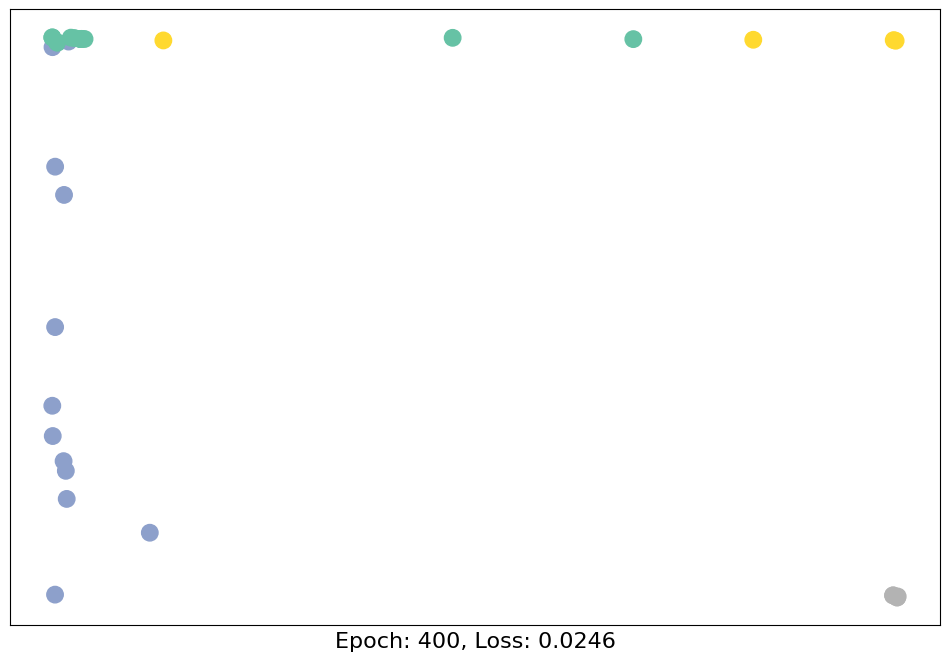

In [25]:
for epoch in range(401):
    loss, h = train(data)
    if epoch % 10 == 0:
        visualize_embedding(h, color=data.y, epoch=epoch, loss=loss)
        time.sleep(0.3)
        ## Added by Me
        final_h = h

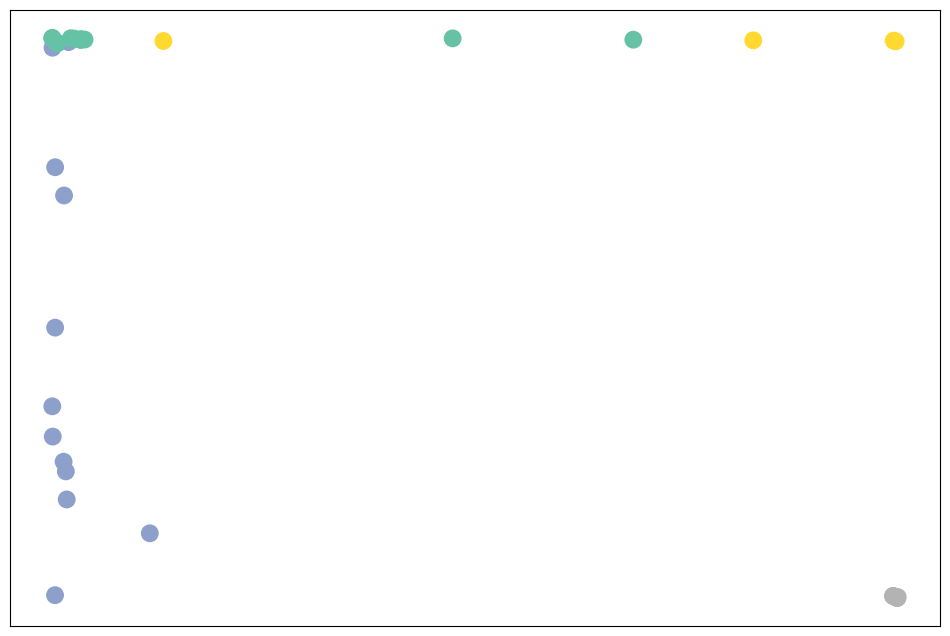

In [26]:
visualize_embedding(h, color=data.y)

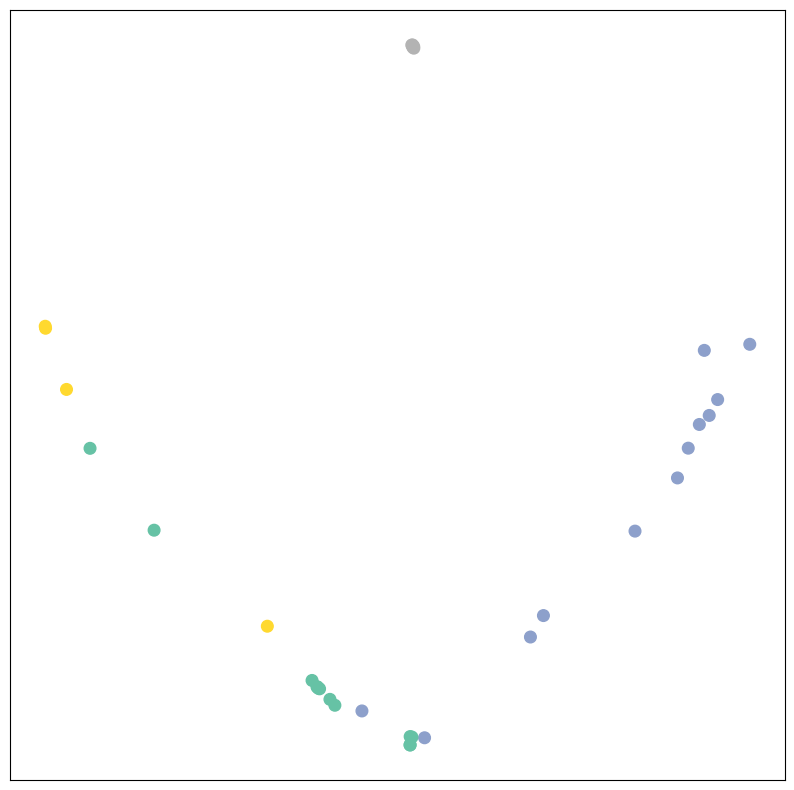

In [27]:
visualize_tsne(h, color=data.y)

# **Result:**
The 3-layer GCN model manages to linearly separating the communities and classifying most of the nodes correctly.

In [28]:
model.eval()
out = model(data.x, data.edge_index)
out

(tensor([[-0.2345,  4.3591, -4.4310,  0.1436],
         [ 1.3456,  2.8111, -2.9429, -1.4126],
         [ 4.3243, -0.1533, -0.0824, -4.3379],
         [ 1.0921,  3.0593, -3.1815, -1.1629],
         [-3.9170,  0.8398,  0.6012,  5.0635],
         [-3.9515,  0.8397,  0.6091,  5.1036],
         [-3.9515,  0.8397,  0.6092,  5.1036],
         [ 1.9870,  2.1490, -2.2986, -2.0382],
         [ 4.3406, -0.2136, -0.0143, -4.3460],
         [ 4.3004, -0.2671,  0.0586, -4.2896],
         [-3.9173,  0.8395,  0.6016,  5.0639],
         [-0.1352,  3.4499, -3.3691,  0.1931],
         [ 0.5090,  3.5199, -3.5986, -0.5685],
         [ 3.3199,  0.8232, -1.0195, -3.3474],
         [ 4.2715, -0.3359,  0.1473, -4.2435],
         [ 4.2691, -0.3384,  0.1509, -4.2402],
         [-3.9464,  0.8293,  0.6204,  5.0996],
         [ 0.7460,  3.2917, -3.3801, -0.8026],
         [ 4.2662, -0.3436,  0.1577, -4.2359],
         [ 3.0462,  1.0192, -1.1912, -3.0647],
         [ 4.2517, -0.3553,  0.1749, -4.2169],
         [ 0.

Note: As we do not have test_mask so we can not check the acuracy of the graph to find what % of the node are correctly set into their correct class.

In [29]:
model.state_dict()

OrderedDict([('conv1.bias', tensor([-0.0398,  0.0074,  0.0530,  0.0303])),
             ('conv1.lin.weight',
              tensor([[ 0.9893, -0.6488, -0.6693, -0.0615,  0.6027,  1.1585,  0.7938, -0.3729,
                       -0.6079, -1.0193,  0.8887, -0.1473,  0.3653, -0.5545, -0.8042, -0.4079,
                        1.0150,  0.2699, -0.9723,  0.0088, -0.6479,  0.1900, -0.3529, -0.5920,
                        0.4493,  0.3951, -0.5013, -0.0678, -1.1910, -1.0785, -1.0772, -0.2185,
                       -0.6120, -0.6529],
                      [-1.0868, -1.3011,  0.2456, -0.7954, -0.4431, -0.2655, -0.8488, -1.2820,
                        0.0860,  0.4040, -0.9798, -0.7531, -1.0100, -0.8316,  0.4007,  0.5778,
                       -0.5675, -1.1067,  0.9949, -1.2402,  0.7423, -1.2624,  0.5717,  0.9572,
                        1.2723,  1.3687,  0.7043,  1.0436,  0.9128,  1.2223,  0.2289,  1.3794,
                        0.5734,  1.0791],
                      [-0.3226,  0.6576,  0.890

In [30]:
model.type

<bound method Module.type of GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)>

In [31]:
model.share_memory

<bound method Module.share_memory of GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)>

In [32]:
model.parameters

<bound method Module.parameters of GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)>

In [33]:
model.get_parameter

<bound method Module.get_parameter of GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)>

In [34]:
model.get_submodule

<bound method Module.get_submodule of GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)>

In [35]:
torch.save(model.state_dict(), 'karate-club.h5')

In [36]:
torch.save(model, 'karate-club_full.h5')

In [37]:
!ls -lah /content

total 32K
drwxr-xr-x 1 root root 4.0K Jul  7 00:35 .
drwxr-xr-x 1 root root 4.0K Jul  6 23:45 ..
drwxr-xr-x 4 root root 4.0K Jul  3 13:21 .config
-rw-r--r-- 1 root root 9.8K Jul  7 00:35 karate-club_full.h5
-rw-r--r-- 1 root root 3.9K Jul  7 00:35 karate-club.h5
drwxr-xr-x 1 root root 4.0K Jul  3 13:21 sample_data
